# DISPERSION

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from ipywidgets import interact

## Group velocity dispersion

Here, we are going to explicitly see the effects of dispersive media on wave-propagation. Dispersive media are characterized by a $\omega$-dependent $\varepsilon$, which, in turn, translates into a $\omega$-dependent propagation velocity.

We are going to simulate a Gaussian wave-packet as it propagates in one dimension through a dispersive medium. The pulse is given by
\begin{equation*}
    \mathbf{E}(x, t) = \hat{\mathbf{y}}\int_{-\infty}^\infty \mathrm{d}k\ e^{-\frac{(k-k_0)^2}{2}\sigma_x^2} \left[e^{i(kx-\omega t)} + e^{-i(kx-\omega t)}\right].
\end{equation*}

The medium's dispersion relation relates $\omega$ to the modulus of the wavevector:
\begin{equation*}
    |\mathbf{k}| = \frac{\omega \sqrt{\varepsilon(\omega)}}{c} , 
\end{equation*}
and can be inverted and approximated by
\begin{equation*}
    \omega (k) = \omega_0 + \omega' (k-k_0) + \frac{\omega''}{2} (k-k_0^2)
\end{equation*}
in a sufficiently narrow range of $k$ values centered at $k_0$.

We can now either (i) use analytical methods to carry out the integration over $k$, or (ii) solve it numerically. In the next cells, we choose certain parameter values for both the pulse and the medium's dispersion relation, and show that the numerical and analytical approaches give the same result: the pulse becomes wider and its amplitude decreases. This is a consequence of different plane waves travelling at different phase velocities:
\begin{equation*}
    v_p = \frac{\omega}{|\mathbf{k}|} = \frac{c}{\sqrt{\varepsilon(w)}}
\end{equation*}

In [36]:
# pulse's parameter values
sigma = 2
k0 = 4

# k-component in the plane wave expansion
Ek = lambda k: np.exp(-(k - k0)**2 / 2 * sigma**2)

# dispersion relation
w0, wp0, wpp0 = 4, 1.2, 2
w = lambda k: w0 + wp0 * (k - k0) + 0.5 * wpp0 * (k - k0)**2

# width and phase functions
Sigmat = lambda t: np.sqrt(np.sqrt(sigma**4 + wpp0**2 * t**2))
phit = lambda t: np.angle(sigma**2 + 1j * wpp0 * t)

In [37]:
ks, dk = np.linspace(k0 - 5 / sigma, k0 + 5 / sigma, 500, retstep=True)
x = np.linspace(-5 * sigma, 15 * sigma, 501)

def Ex_num(t):
    return sum(2 * Ek(k) * np.cos(k*x - w(k)*t) for k in ks) * dk

def Ex_ana(t):
    return 2 * np.real(
        np.sqrt(2 * np.pi) / Sigmat(t) * np.exp(-1j * phit(t)/2) *
        np.exp(-(x - wp0 * t)**2 / 2 / Sigmat(t)**2 * np.exp(-1j * phit(t))) *
        np.exp(1j * (k0 * x - w0 * t))
    )

interactive(children=(FloatSlider(value=0.0, description='t', max=15.0), Output()), _dom_classes=('widget-inte…

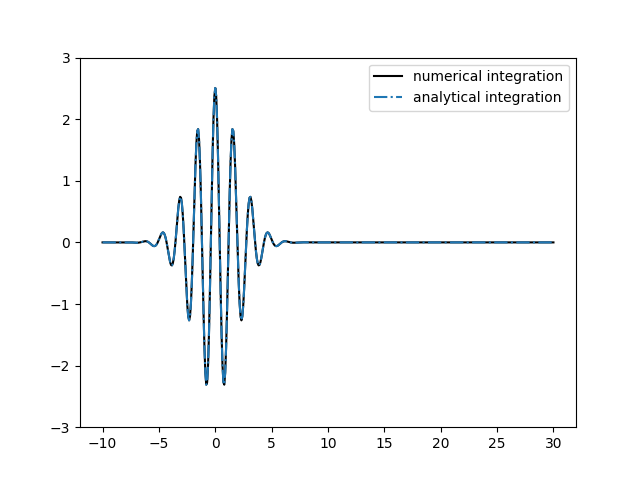

In [38]:
fig, ax = plt.subplots(1, 1)
line_num, = ax.plot(x, Ex_num(0), c="k", label="numerical integration")
line_ana, = ax.plot(x, Ex_ana(0), ls="-.", label="analytical integration")
ax.set_ylim(-3, 3)
ax.legend()

@interact(t=(0, 15, 0.1))
def time_evol(t=0):
    line_num.set_ydata(Ex_num(t))
    line_ana.set_ydata(Ex_ana(t))

## Reflection and transmition (normal incidence)

We consider now two media occupying an infinite half-space with a planar boundary at $x = 0$, and imagine a Gaussian pulse that propagates in the first medium towards the second. To analyze the process, we need to write the basic solutions to the problem that we derived in class. The idea is that we know perfectly well how these field-profiles evolve in time (monochromatic). These basic solutions are the sum of the incident and reflected fields when $x<0$, and the transmitted field when $x\geq 0$. Our next step will be to express the Gaussian pulse in terms of these basic solutions, and add the evolution of all basic solutions to obtain the evolution of the full pulse.

Let us consider a first medium with $\epsilon_1 = 1$ and another with a Drude-Lorentz permittivity: 

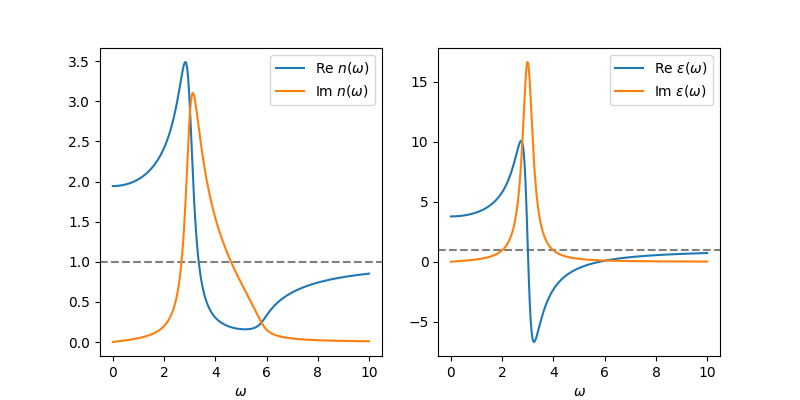

In [28]:
# Drude-Lorentz model parameters
wp = 5
w0 = 3
gamma = 0.5

# frequency array
w = np.linspace(0, 10, 300)

# complex Drude-Lorentz permittivity
epsilon = lambda w: 1 + wp**2 / (w0**2 - w**2 - 1j * gamma * w)

# complex refractive index 
n = lambda w: np.sqrt(epsilon(w))

# plot
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].axhline(y=1, c="gray", ls="--")
axs[1].axhline(y=1, c="gray", ls="--")

axs[0].plot(w, n(w).real, label=r"$\text{Re}~n(\omega)$")
axs[0].plot(w, n(w).imag, label=r"$\text{Im}~n(\omega)$")
axs[1].plot(w, epsilon(w).real, label=r"$\text{Re}~\varepsilon(\omega)$")
axs[1].plot(w, epsilon(w).imag, label=r"$\text{Im}~\varepsilon(\omega)$")
for ax in axs:
    ax.set_xlabel(r"$\omega$")
    ax.legend()
    # ax.set_yscale("log")

Then, we may use the Fresnel coefficients to write the basic solutions to Maxwell's equations in this piecewise homogeneous medium. For simplicity, we assume that the incidence angle is $\theta_i=0$. A basic solution is plotted below:

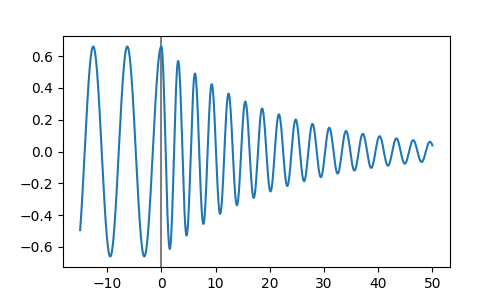

In [33]:
# refractive indices
n_neg = lambda w: 1  # left of the boundary (medium 1)
n_pos = lambda w: np.sqrt(epsilon(w))  # right of the boundary (medium 2)

# basic solutions
def f(w, x):
    # negative region 
    f_neg = (
                np.exp(1j*(w * n_neg(w) * x))   # incident wave
                + (1 - n_pos(w)) / (1 + n_pos(w)) * np.exp(1j*(- w * n_neg(w) * x))  # reflected wave (Fresnel coefficient * wave)
            ) * (x < 0)  # this last term acts like a step filter 
    # positive region
    f_pos = 2 / (1 + n_pos(w)) * np.exp(1j*(w * n_pos(w) * x)) * (x >= 0)  # transmitted wave (Fresnel coefficient * wave)

    return f_neg + f_pos

# basic solution (f) plot
x = np.linspace(-15, 50, 5000)
fig = plt.figure(figsize=(5, 3))
plt.axvline(x=0, c="gray")
plt.plot(x, f(1, x).real)

We create a pulse as a linear combination of these basic functions with a Gaussian profile again.

In [ ]:
# pulse parameters
sigma_w = 0.1
wc = 3.1  # maximum value of Im(n) ==> nothing is transmitted, most is reflected. metal-like behavior
wc = 1.3  # part is transmitted, part is reflected. typical dielectric behavior.
wc = 20   # epsilon converges to 1, almost all is transmitted (residual losses)
x = np.linspace(-50, 50, 5000)

# w-component in the plane wave expansion
Ew = lambda w: 1 / sigma_w * np.exp(-(w - wc)**2 / 2 / sigma_w**2)

# pulse
ws, dw = np.linspace(wc - 3 * sigma_w, wc + 3 * sigma_w, 200, retstep=True)
def Ex_num(t):
    return sum(Ew(w) * f(w, x) * np.exp(-1j * w * t) for w in ws).real * dw

interactive(children=(FloatSlider(value=-50.0, description='t', max=50.0, min=-50.0), Output()), _dom_classes=…

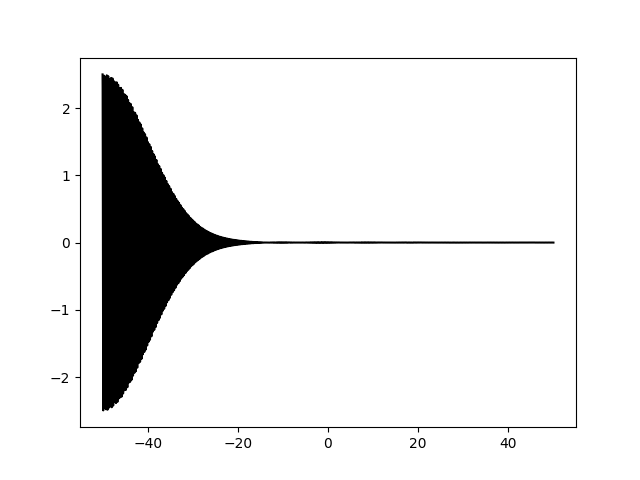

In [50]:
fig, ax = plt.subplots(1, 1)
line_num, = ax.plot(x, Ex_num(-50), c="k")

@interact(t=(-50, 50, 0.1))
def time_evol(t=-50):
    line_num.set_ydata(Ex_num(t))